## **OpenFace features used for regression**

### **Preprocessing and research**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import collections
import glob as gb

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/DIPLOMA/EngagementWild_2020/OpenFace_features/Engagement_Labels_Engagement.csv', header=None, sep=';').iloc[0:198, 0:2]
labels = labels.dropna(axis=0).drop_duplicates().reset_index()  # there were dupliucated rows
labels.columns = ['index', 'video_name', 'intensity_level']
labels['intensity_level'] = [float(i.replace(',', '.')) for i in labels['intensity_level']]
labels[70:82]

,index,video_name,intensity_level
70,72,subject_32_Vid_7,0.33
71,73,subject_33_Vid_1,0.33
72,74,subject_33_Vid_2,0.66
73,75,subject_33_Vid_3,0.66
74,76,subject_33_Vid_4,0.66
75,77,subject_33_Vid_7,0.66
76,78,subject_34_Vid_7,1.00
77,79,subject_34_Vid_1,0.66
78,80,subject_34_Vid_5,0.66
79,81,subject_35_Vid_6,0.33


In [ ]:
set(labels['intensity_level'])

{0.0, 0.33, 0.66, 1.0}

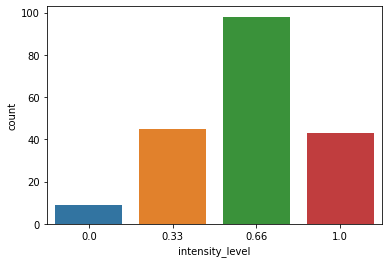

In [ ]:
sns.countplot(x = 'intensity_level', data=labels)

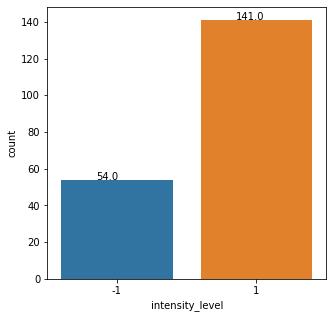

In [ ]:
labels['intensity_level'] = labels['intensity_level'].replace([0, 0.33, 0.66, 1], [-1, -1, 1, 1]).astype(int)
# sns.countplot(x = 'intensity_level', data=data)
plt.figure(figsize=(5,5))
ax = sns.countplot(x = 'intensity_level', data=labels)

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
train_path = '/content/drive/MyDrive/DIPLOMA/EngagementWild_2020/OpenFace_features/Train/'
val_path = '/content/drive/MyDrive/DIPLOMA/EngagementWild_2020/OpenFace_features/validation/'

train_names = [i.replace(train_path, '').replace('.txt', '') for i in gb.glob(train_path + '*.txt')]
val_names = [i.replace(val_path, '').replace('.txt', '') for i in gb.glob(val_path + '*.txt')]
# train_names

In [ ]:
def make_std_dataset(vid_names, folder_path, labels_df=labels):  # labels is the common csv for both train and val
    cnt = 0
    ord_labels = []
    vid_frames_number = []  # for minimal frames number counter
    for s_name in vid_names:  # iteration over train/val set
        cur = pd.read_csv(folder_path + s_name + '.txt')  # folder_path path to train/val features folder

        # features datasets preprocessing
        # there are unneeded extra spaces in column names
        col_names_new = []

        for c in cur.columns:
            col_names_new.append(c.replace(' ', ''))

        d = {i: j for i, j in zip(cur.columns, col_names_new)}
        cur = cur.rename(columns=d)
        cur = cur[cur['success']==1].drop(['frame', 'timestamp', 'success'], axis=1).astype(float).dropna()
        
        # count of frames number in each video after dropna
        vid_frames_number.append(len(cur))

        # making std_dataset
        if cnt == 0:
            # create std dataset
            std_df = pd.DataFrame(cur.std(), columns=[s_name]).transpose().reset_index()
            cnt+=1
        else:
            # add new rows into dataset
            tmp = pd.DataFrame(cur.std(), columns=[s_name]).transpose().reset_index()
            std_df = pd.concat((std_df, tmp))

        lab = labels_df[labels_df['video_name']==s_name]['intensity_level']
        ord_labels.append(float(lab) if not lab.empty else None)
      
    ord_labels = pd.Series(ord_labels)
    ord_labels.fillna(ord_labels.median(), inplace=True)

    std_df.fillna(std_df.mean(), inplace=True)

    print('Minimal frames number in each video', min(vid_frames_number))
    return std_df, ord_labels

In [ ]:
def make_agg_dataset(vid_names, folder_path, labels_df=labels):  # labels is the common csv for both train and val
    cnt = 0
    ord_labels = []
    vid_frames_number = []
    for s_name in vid_names:  # iteration over train/val set
        cur = pd.read_csv(folder_path + s_name + '.txt')  # folder_path path to train/val features folder

        # features datasets preprocessing
        # there are unneeded extra spaces in column names
        col_names_new = []

        for c in cur.columns:
            col_names_new.append(c.replace(' ', ''))

        d = {i: j for i, j in zip(cur.columns, col_names_new)}
        cur = cur.rename(columns=d)
        cur = cur[cur['success']==1].drop(['frame', 'timestamp', 'success'], axis=1).astype(float).dropna()
        
        # count of frames number in each video after dropna
        vid_frames_number.append(len(cur))

        # making std_dataset
        if cnt == 0:
            # create std dataset
            std_df = pd.DataFrame(cur.std(), columns=[s_name]).transpose()
            std_df.rename(columns = dict(zip(std_df.columns, [x + "_std" for x in std_df.columns])), inplace = True)

            mean_df = pd.DataFrame(cur.mean(), columns=[s_name]).transpose()
            mean_df.rename(columns = dict(zip(mean_df.columns, [x + "_mean" for x in mean_df.columns])), inplace = True)

            min_df = pd.DataFrame(cur.min(), columns=[s_name]).transpose()
            min_df.rename(columns = dict(zip(min_df.columns, [x + "_min" for x in min_df.columns])), inplace = True)

            max_df = pd.DataFrame(cur.max(), columns=[s_name]).transpose()
            max_df.rename(columns = dict(zip(max_df.columns, [x + "_max" for x in max_df.columns])), inplace = True)

            all_features = pd.concat((std_df, mean_df, min_df, max_df), axis=1)
            cnt+=1
        else:
            # add new rows into dataset
            tmp1 = pd.DataFrame(cur.std(), columns=[s_name]).transpose()
            tmp1.rename(columns = dict(zip(tmp1.columns, [x + "_std" for x in tmp1.columns])), inplace = True)

            tmp2 = pd.DataFrame(cur.mean(), columns=[s_name]).transpose()
            tmp2.rename(columns = dict(zip(tmp2.columns, [x + "_mean" for x in tmp2.columns])), inplace = True)

            tmp3 = pd.DataFrame(cur.min(), columns=[s_name]).transpose()
            tmp3.rename(columns = dict(zip(tmp3.columns, [x + "_min" for x in tmp3.columns])), inplace = True)

            tmp4 = pd.DataFrame(cur.max(), columns=[s_name]).transpose()
            tmp4.rename(columns = dict(zip(tmp4.columns, [x + "_max" for x in tmp4.columns])), inplace = True)

            tmp = pd.concat((tmp1, tmp2, tmp3, tmp4), axis=1)
            all_features = pd.concat((all_features, tmp))

        lab = labels_df[labels_df['video_name']==s_name]['intensity_level']
        ord_labels.append(float(lab) if not lab.empty else None)
      
    ord_labels = pd.Series(ord_labels)
    ord_labels.fillna(ord_labels.median(), inplace=True)

    all_features.fillna(all_features.mean(), inplace=True)

    print('Minimal frames number in each video', min(vid_frames_number))

    return all_features.reset_index(), ord_labels

In [ ]:
x_train, y_train = make_std_dataset(train_names, train_path)
# x_train, y_train = make_agg_dataset(train_names, train_path)
x_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260

Minimal frames number in each video 882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,index,confidence,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,pose_Tx,pose_Ty,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,subject_26_Vid_2,0.009962,0.043714,0.031580,0.010530,0.045143,0.035897,0.016400,10.279993,7.526921,...,0.058583,0.150684,0.241917,0.180695,0.230680,0.387693,0.266682,0.223933,0.225217,0.448819
0,subject_26_Vid_1,0.013671,0.042271,0.036237,0.008356,0.042888,0.030995,0.013170,7.872007,11.444243,...,0.058207,0.222399,0.186380,0.178575,0.087124,0.496829,0.264426,0.212908,0.413304,0.470576
0,subject_26_Vid_4,0.007836,0.052306,0.040387,0.008180,0.051258,0.045164,0.012642,8.999557,8.192133,...,0.059142,0.139200,0.101185,0.167819,0.111376,0.436257,0.351007,0.198747,0.492189,0.472376
0,subject_26_Vid_3,0.025449,0.026322,0.037811,0.007464,0.035270,0.028314,0.009099,6.863779,11.579220,...,0.000000,0.299247,0.156235,0.079977,0.037796,0.500173,0.194410,0.166716,0.304909,0.438501
0,subject_26_Vid_5,0.021504,0.070332,0.060920,0.013265,0.064745,0.052170,0.018471,12.574683,14.990007,...,0.075438,0.278635,0.239552,0.234618,0.229151,0.489981,0.355912,0.294698,0.499883,0.477111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,subject_84_Vid_3,0.049709,0.075480,0.061924,0.013913,0.074454,0.065004,0.016104,30.042361,16.960395,...,0.166599,0.470240,0.302773,0.376897,0.242457,0.460391,0.333570,0.381981,0.111294,0.314755
0,subject_84_Vid_5,0.036655,0.055677,0.057727,0.008860,0.054766,0.056756,0.011459,16.673370,27.884571,...,0.128501,0.489913,0.241941,0.440614,0.244563,0.359270,0.258366,0.367551,0.027012,0.257152
0,subject_85_Vid_7,0.032002,0.056129,0.054983,0.007429,0.059702,0.067548,0.007802,14.253648,12.847444,...,0.066990,0.188871,0.234146,0.384463,0.270639,0.292488,0.482206,0.454451,0.377125,0.433422
0,subject_86_Vid_7,0.017852,0.039097,0.031935,0.001604,0.036149,0.034617,0.008170,12.294394,8.956235,...,0.000000,0.000000,0.223068,0.311640,0.101946,0.218232,0.354554,0.226221,0.067359,0.381653


In [ ]:
X_val, y_val = make_std_dataset(val_names, val_path)
# X_val, y_val = make_agg_dataset(val_names, val_path)
X_val

Minimal frames number in each video 2413


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,index,confidence,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,pose_Tx,pose_Ty,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,subject_1_Vid_2,4.101993e-03,0.091192,0.066996,0.014037,0.070427,0.065169,0.015573,10.609368,16.227964,...,0.116786,0.168359,0.201180,0.368568,0.155452,0.476563,0.342586,0.218223,0.145721,0.426693
0,subject_1_Vid_1,4.031074e-03,0.066524,0.070324,0.013203,0.058180,0.070941,0.015980,8.324711,15.974430,...,0.045950,0.052529,0.164024,0.290573,0.066145,0.426043,0.283375,0.240882,0.095871,0.392133
0,subject_1_Vid_3,4.704389e-03,0.077186,0.063829,0.016164,0.074753,0.066163,0.017125,16.489658,13.375485,...,0.083848,0.109618,0.231164,0.328132,0.194108,0.413548,0.321978,0.339272,0.161704,0.396620
0,subject_1_Vid_4,8.018390e-03,0.064983,0.055983,0.009900,0.049737,0.048448,0.010634,7.560600,11.452113,...,0.126848,0.169649,0.181626,0.365931,0.213378,0.475728,0.337846,0.258032,0.095308,0.420903
0,subject_2_Vid_6,2.604418e-02,0.049990,0.037709,0.013690,0.061977,0.037470,0.009261,25.513704,7.480045,...,0.160039,0.460383,0.218012,0.288589,0.166260,0.303351,0.460429,0.322095,0.217568,0.475019
0,subject_1_Vid_5,5.694555e-03,0.081271,0.058149,0.013367,0.053080,0.053169,0.015565,8.331672,13.772388,...,0.086950,0.123283,0.204886,0.371546,0.270972,0.376351,0.360541,0.310965,0.142882,0.418345
0,subject_3_Vid_2,5.263018e-14,0.046999,0.036948,0.011768,0.043441,0.037859,0.012794,6.272857,8.090760,...,0.152058,0.485782,0.095342,0.237006,0.368401,0.117827,0.257972,0.230962,0.054572,0.470491
0,subject_3_Vid_1,4.357808e-03,0.053108,0.054716,0.010945,0.046649,0.061061,0.012570,9.374263,21.306483,...,0.189731,0.409238,0.373786,0.339339,0.361509,0.080423,0.323793,0.427075,0.171357,0.476184
0,subject_3_Vid_3,5.440660e-14,0.038023,0.027383,0.008814,0.041683,0.028698,0.009961,6.065982,6.657069,...,0.082690,0.491978,0.070585,0.144320,0.238806,0.000000,0.233747,0.282451,0.167809,0.369133
0,subject_3_Vid_4,4.525335e-03,0.044938,0.034774,0.011945,0.045628,0.037941,0.013779,10.840961,12.111711,...,0.101460,0.486691,0.150412,0.091479,0.294562,0.144693,0.354900,0.248876,0.041992,0.404074


## **Machine Learning - training and validation**

In [ ]:
!pip install mord

  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=a5757464e5aed66d318b59a5a63c446d61962a1ea30d175a9ae8a5eb7491d764
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, RidgeClassifier, LogisticRegression, Lasso
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

from mord import OrdinalRidge, LogisticAT, LogisticIT, LAD

import numpy as np

In [ ]:
def print_metrics(y_test, y_pred):
    print(f'mean_squared_error_score:    {mean_squared_error(y_test, y_pred)}')
    print(f'r2_score:                    {r2_score(y_test, y_pred)}')

In [ ]:
X_train = x_train.drop('index', axis=1)
y_train_fl = y_train  # regression
y_train_bin = y_train.replace([0, 0.33, 0.66, 1], [-1, -1, 1, 1]).astype(int)  # binary classification


X_test = X_val.drop('index', axis=1)
y_test_fl = y_val  # regression
y_test_bin = y_val.replace([0, 0.33, 0.66, 1], [-1, -1, 1, 1]).astype(int)  # binary classification

In [ ]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# X_train_norm = normalize(X_train, norm='l2')
# X_test_norm = normalize(X_test, norm='l2')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
def draw_conf_matrix(y_true_fl, y_pred):
    level = sorted(list(set(labels['intensity_level'])))
    print(level)
    y_pred_round = []
    for y in y_pred:
        y_pred_round.append([str(i) for i in level if abs(y - i) == min(abs(y - j) for j in level)][0])

    # y_pred_round

    cm = confusion_matrix(y_true_fl.astype(str), y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=level)
    disp.plot()

**RIDGE**

In [ ]:
clf = Ridge(alpha=10, max_iter=10000)
clf.fit(X_train_norm, y_train_fl)
y_pred = clf.predict(X_test_norm)

print_metrics(y_test_fl, y_pred)

mean_squared_error_score:    0.09526848236950916
r2_score:                    0.03676670142630545


[0.0, 0.33, 0.66, 1.0]


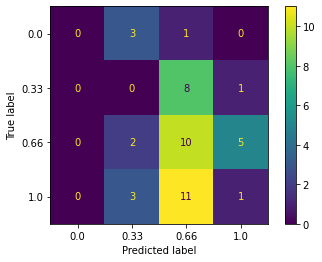

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

**Random Forest**

In [ ]:
clf = RandomForestRegressor(max_depth=10, n_jobs=-1, oob_score=True)

clf.fit(X_train_norm, y_train_fl)
y_pred = clf.predict(X_test_norm)
print_metrics(y_test_fl, y_pred)
clf.oob_score_

mean_squared_error_score:    0.09152832068879617
r2_score:                    0.07458244261696334


0.333317002600488

[0.0, 0.33, 0.66, 1.0]


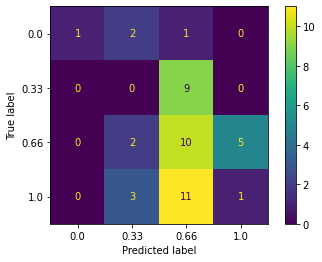

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

**SVC with rbf kernel**

In [ ]:
clf = svm.SVR(kernel='rbf')
clf.fit(X_train_norm, y_train_fl)
y_pred = clf.predict(X_test_norm)
print_metrics(y_test_fl, y_pred)

mean_squared_error_score:    0.08593233987969104
r2_score:                    0.13116185817438575


[0.0, 0.33, 0.66, 1.0]


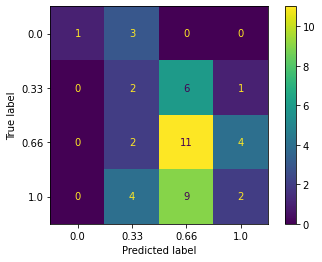

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

### **MORD**

In [ ]:
clf = OrdinalRidge(alpha=0.5)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print_metrics(y_test_fl, pd.Series(y_pred).replace([1, 2, 3], [0.33, 0.66, 1]))

mean_squared_error_score:    0.2783333333333333
r2_score:                    -1.8141514181975058


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


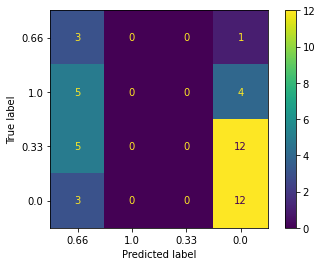

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

### **With research interest the task can be transformed to binary classification problem**

In [ ]:
def print_metrics(y_test, y_pred):
    print(f'f1_score:                    {f1_score(y_test, y_pred, average="macro")}')
    print(f'precision_score:             {precision_score(y_test, y_pred, average="macro").round(2)}')
    print(f'recall_score:                {recall_score(y_test, y_pred, average="macro").round(2)}')
    print(f'accuracy_score:              {accuracy_score(y_test, y_pred).round(2)}')
    print(f'balanced_accuracy_score:     {balanced_accuracy_score(y_test, y_pred).round(2)}')

In [ ]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()

**RIDGE**

In [ ]:
clf = RidgeClassifier(alpha=0.1, normalize=True, max_iter=10000)
clf.fit(X_train_norm, y_train_bin)
y_pred = clf.predict(X_test_norm).round()

print_metrics(y_test_bin, y_pred)

f1_score:                    0.6590909090909091
precision_score:             0.67
recall_score:                0.65
accuracy_score:              0.73
balanced_accuracy_score:     0.65


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


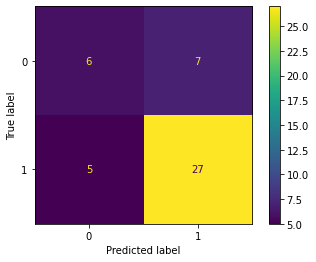

In [ ]:
conf_matrix(y_test_bin, y_pred)

**Logistic regression**

In [ ]:
lr = LogisticRegression(random_state=17, class_weight = "balanced")

model = lr.fit(X_train_norm, y_train_bin)
y_pred = model.predict(X_test_norm)

print_metrics(y_test_bin, y_pred)

f1_score:                    0.7159090909090909
precision_score:             0.73
recall_score:                0.71
accuracy_score:              0.78
balanced_accuracy_score:     0.71


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


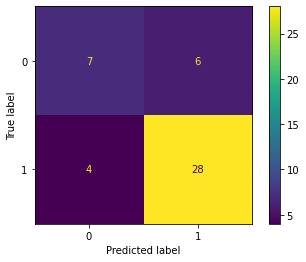

In [ ]:
conf_matrix(y_test_bin, y_pred)

**Random Forest**

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, criterion = 'entropy', max_depth=10, n_jobs=-1, oob_score=True)

clf.fit(X_train_norm, y_train_bin)
y_pred = clf.predict(X_test_norm)
print_metrics(y_test_bin, y_pred)
clf.oob_score_

f1_score:                    0.5341614906832297
precision_score:             0.55
recall_score:                0.54
accuracy_score:              0.67
balanced_accuracy_score:     0.54


0.7557251908396947

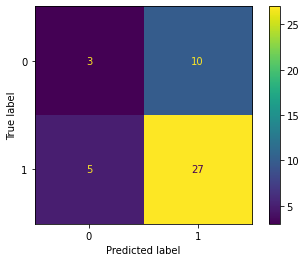

In [ ]:
conf_matrix(y_test_bin, y_pred)